# Evaluation

This notebook evaluates the **content-based movie recommender** (tag vectors + cosine similarity) using a small set of metrics. All logic is self-contained; no external metrics module is required.

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer

# Resolve project root (notebook may be run from project root or from src/evaluation)
_cwd = Path(".").resolve()
for _r in [_cwd, _cwd.parent, _cwd.parent.parent]:
    if (_r / "data" / "processed" / "movies_merge.csv").exists():
        ROOT = _r
        break
else:
    ROOT = _cwd
DATA_PATH = ROOT / "data" / "processed" / "movies_merge.csv"
df = pd.read_csv(DATA_PATH)

# Same pipeline as training: stem tags, vectorize, cosine similarity
ps = PorterStemmer()
df = df.copy()
df["tags"] = df["tags"].fillna("").apply(lambda t: " ".join(ps.stem(w) for w in str(t).split()))
cv = CountVectorizer(max_features=5000, stop_words="english")
vectors = cv.fit_transform(df["tags"]).toarray()
similarity = cosine_similarity(vectors)
print("Data loaded:", len(df), "movies. Similarity shape:", similarity.shape)

Data loaded: 4805 movies. Similarity shape: (4805, 4805)


## Metrics (English)

- **Precision@K**: Among the top-K recommended movies, the fraction that are "relevant". We define relevant as sharing at least one tag with the query movie.
- **Catalog Coverage**: Fraction of all movies that appear in at least one top-K recommendation list (higher = more variety).
- **Intra-list Diversity**: Average, per list, of (1 − mean pairwise cosine similarity) among recommended items (higher = more diverse recommendations).

In [4]:
SAMPLE_SIZE = 500   # number of query movies to evaluate; use None for full catalog
K = 5
np.random.seed(42)
n_eval = len(df) if SAMPLE_SIZE is None else min(SAMPLE_SIZE, len(df))
sample_idx = np.random.choice(len(df), size=n_eval, replace=False)

def get_top_k(sim_row, idx, k=K):
    order = np.argsort(sim_row)[::-1]
    return [j for j in order if j != idx][:k]

def tags_set(i):
    return set(str(df.iloc[i]["tags"]).split())

# Build recommendations and relevance
precision_list = []
all_rec_indices = []
diversity_list = []
for idx in sample_idx:
    recs = get_top_k(similarity[idx], idx, K)
    all_rec_indices.extend(recs)
    query_tags = tags_set(idx)
    relevant = sum(1 for j in recs if query_tags & tags_set(j))
    precision_list.append(relevant / K)
    if len(recs) >= 2:
        pairs = np.triu(similarity[np.ix_(recs, recs)], k=1)
        n_pairs = (len(recs) * (len(recs) - 1)) // 2
        mean_sim = pairs.sum() / n_pairs
        diversity_list.append(1.0 - mean_sim)

precision_at_k = np.mean(precision_list)
coverage = len(set(all_rec_indices)) / len(df)
diversity = np.mean(diversity_list) if diversity_list else 0.0

print(f"Precision@{K}: {precision_at_k:.4f}")
print(f"Catalog Coverage: {coverage:.4f} ({coverage*100:.2f}%)")
print(f"Average Intra-list Diversity: {diversity:.4f}")

Precision@5: 1.0000
Catalog Coverage: 0.3091 (30.91%)
Average Intra-list Diversity: 0.7555


## Summary Plot

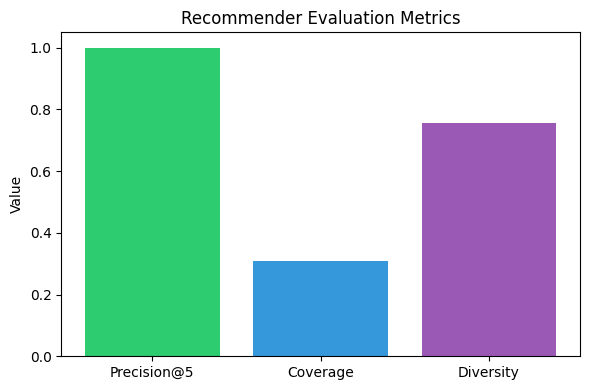

In [5]:
import matplotlib.pyplot as plt

metrics_dict = {"Precision@5": precision_at_k, "Coverage": coverage, "Diversity": diversity}
plt.figure(figsize=(6, 4))
plt.bar(metrics_dict.keys(), metrics_dict.values(), color=["#2ecc71", "#3498db", "#9b59b6"])
plt.ylabel("Value")
plt.title("Recommender Evaluation Metrics")
plt.tight_layout()
plt.show()

## Metric Definitions

| Metric | Description |
|--------|-------------|
| **Precision@K** | Fraction of top-K recommendations that share at least one tag with the query movie. |
| **Catalog Coverage** | Fraction of the catalog that appears in at least one top-K list; higher = more variety. |
| **Intra-list Diversity** | 1 minus mean pairwise cosine similarity within each list; higher = more diverse. |

Change `SAMPLE_SIZE` or `K` in the metrics cell to re-run the evaluation.